In [94]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [95]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")

In [96]:
boston_series = {"Monthly Boston armed robberies": robberies_in_boston["Count"]}

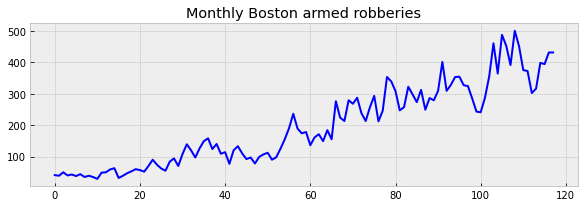

In [97]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(boston_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        boston_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [98]:
boston_series_stationary = boston_series.copy()
print('Results of Dickey-Fuller Test:')
for key, series in boston_series.items():
    print(key)
    dftest = adfuller(series, autolag='AIC')
    p_value = dftest[1]
    print(f'p-value = {p_value}')
    if p_value > 0.05:
        series = boxcox(series, 0)
        dftest = adfuller(series, autolag='AIC')
        p_value = dftest[1]
        print(f'p-value after boxcox transformation: {p_value}')
    if p_value > 0.05:
        series = np.diff(series, 1)
        dftest = adfuller(series, autolag='AIC')
        p_value = dftest[1]
        print(f'p-value after differentiation: {p_value}')
    boston_series_stationary[key] = pd.Series(series)

Results of Dickey-Fuller Test:
Monthly Boston armed robberies
p-value = 0.9942775638057232
p-value after boxcox transformation: 0.28083250354255435
p-value after differentiation: 2.378602441743682e-11


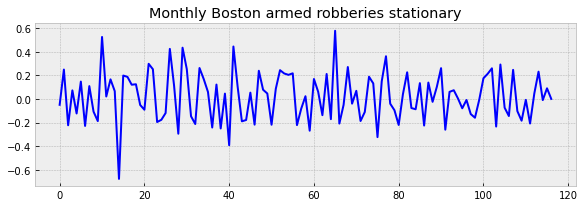

In [99]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(boston_series_stationary.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        boston_series_stationary[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key + ' stationary')

    plt.tight_layout()

## Скользящее среднее и взвешенное скользящее среднее
Модели выбраны из-за своей простоты

In [100]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [101]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [102]:
series_aver = moving_average(boston_series["Monthly Boston armed robberies"], 7)
series_stationary_aver = moving_average(boston_series_stationary["Monthly Boston armed robberies"], 7)
series_weight_aver = weighted_moving_average(boston_series["Monthly Boston armed robberies"], 7, [1,1,2,3,5,8,13])
series_stationary_weight_aver = weighted_moving_average(boston_series_stationary["Monthly Boston armed robberies"], 7, [1,1,2,3,5,8,13])

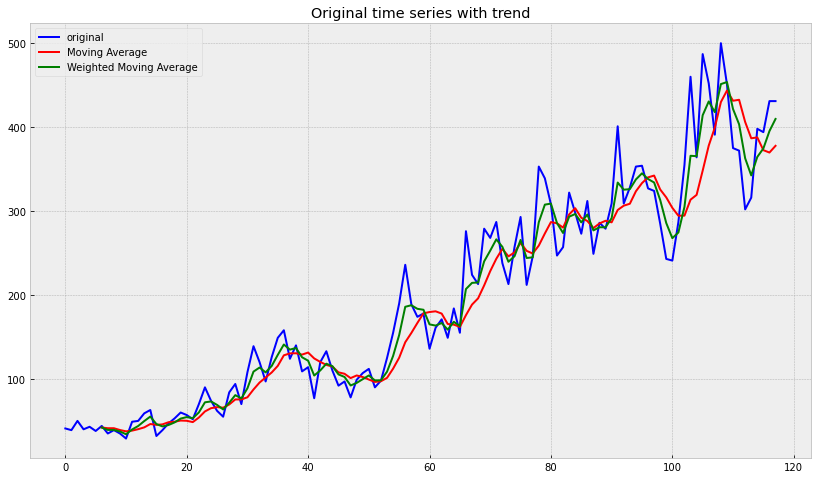

In [103]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_series["Monthly Boston armed robberies"], color='blue',label='original')
    plt.plot(series_aver, color='red', linewidth='2', label='Moving Average')
    plt.plot(series_weight_aver, color='green', linewidth='2', label='Weighted Moving Average')
    plt.title('Original time series with trend')
    plt.legend()

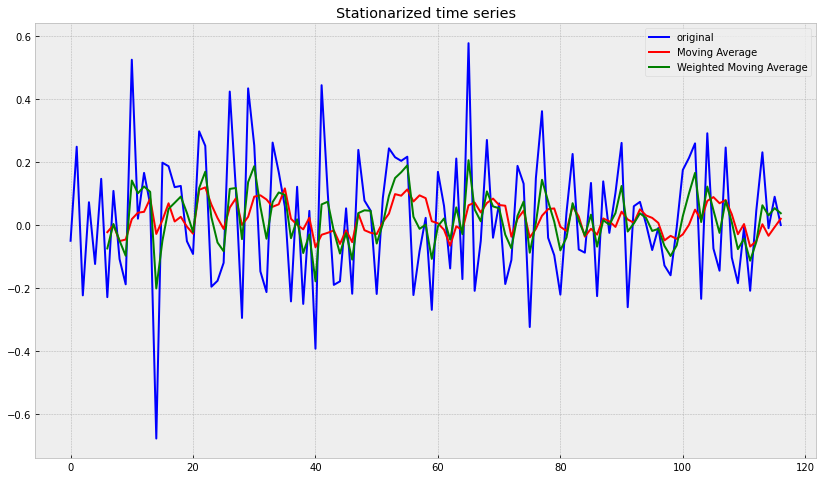

In [104]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_series_stationary["Monthly Boston armed robberies"], color='blue',label='original')
    plt.plot(series_stationary_aver, color='red', linewidth='2', label='Moving Average')
    plt.plot(series_stationary_weight_aver, color='green', linewidth='2', label='Weighted Moving Average')
    plt.title('Stationarized time series')
    plt.legend()

Модель использующая взвешенное скользящее среднее сработала лучше и для стационарного и нестационарного рядов

## Экспоненциальное сглаживание

In [105]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [106]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

Для стационарного ряда выбрана модель экспоненциального сглаживания
Наилучшее качество достигается при альфа = 0.8

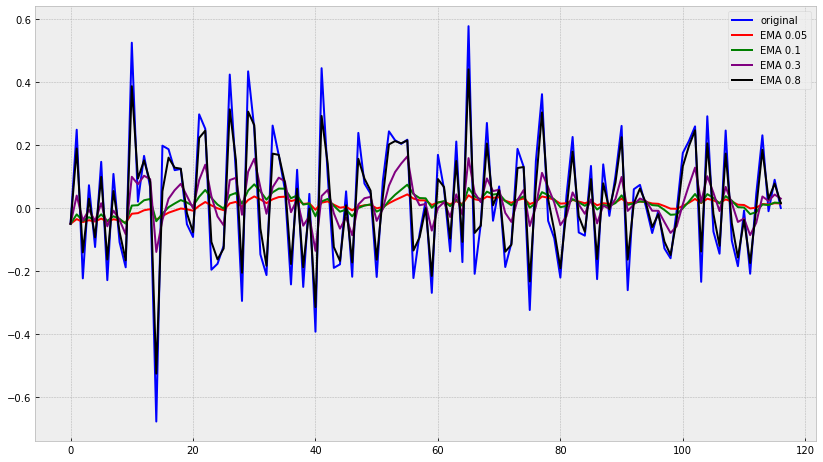

In [107]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_series_stationary["Monthly Boston armed robberies"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(boston_series_stationary["Monthly Boston armed robberies"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Для нестационарного ряда с трендом выбрана модель двойного экспоненциального сглаживания
Наилучшее качество достигается при альфа = 0.8 и бета = 0.2

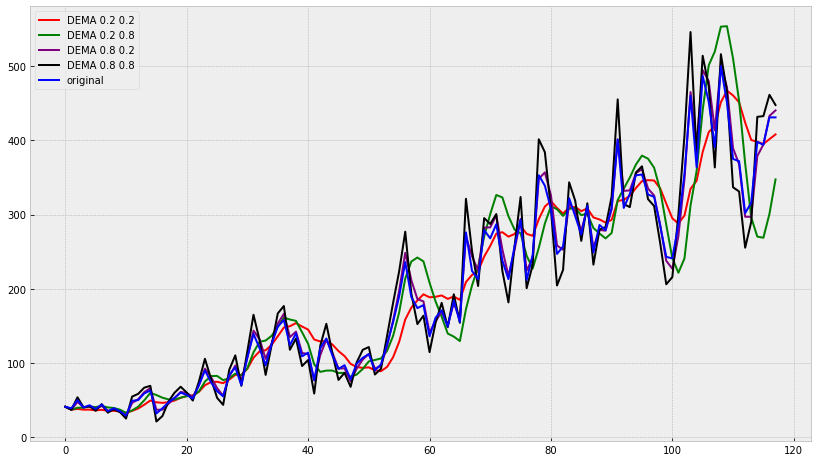

In [108]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser= double_ema(boston_series["Monthly Boston armed robberies"], alphas[i], bettas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(boston_series["Monthly Boston armed robberies"], color='blue',label='original')
    plt.legend()